# Larval fish recruitment behavior in Hawaii

- Release dates = 1 March 2010 - 30 April 2010, 100 larval-fish daily from each release location (61 days)
- Duration simulation = 1 March 2010 - 15 June 2010 (107 days)

## Understanding “recruitment behavior”/“settlement behavior”
For a particle to be considered “recruited”, it has to be within a 5 km radius of the release sites on day 45. If the particle settles, stop the particle and flag it. The goal is to know how many baby fish (particles) come back to where they came from. That percentage is important to know if fish population in Hawaii will be sustainable.

In [5]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile, ErrorCode
from datetime import timedelta
import numpy as np
from scipy.io import netcdf
from netCDF4 import Dataset
import pandas as pd
import random as rndm

from mpl_toolkits.basemap import Basemap

import csv
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pickle as pickle

import time

filenames = {'U': "../MITgcm_data/UV*.cdf",
             'V': "../MITgcm_data/UV*.cdf"}

In [23]:
import parcels
print(parcels.__file__)
from parcels import rng as random
import math

/Users/michelleho/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/parcels/__init__.pyc


In [8]:
variables = {'U': 'U',
             'V': 'V'}
dimensions = {'time': 'TIME1','depth': 'DEPTH_T1_4',
              'lat': 'LATITUDE_T',
              'lon': 'LONGITUDE_U'}

In [10]:
now = time.time()

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

time_elapsed = time.time()-now
print('time elapsed (s): ', time_elapsed)

('time elapsed (s): ', 38.1315438747406)


In [11]:
def DeleteParticle(particle, fieldset, time, dt):
    particle.delete()

In [115]:
def turbVal(particle, fieldset, time, dt):
    # This if-statement is meant to trigger when the current time is a quarter interval of the model timestep
    # but I'm not sure it's working... need to double-check
#     random.seed(1234)
    if math.fmod(time,dt/4) == 0:
        horDiff = 100
        uturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1) # Important! Should this be random.random()???
        # should set random seed somewhere too...?
        particle.lat += uturb * dt/1.1e5
        vturb = math.sqrt(((2*horDiff)/dt)) * random.uniform(-1,1)
        particle.lon += vturb * dt/1.1e5

In [90]:
# release locations

release_locations = pd.read_csv('ReefCellData_for_Johanna_23June2014.csv', header=None, names=['value','name','code','latitude','longitude'])

In [91]:
release_locations.head()

,value,name,code,latitude,longitude
0,0.066875,Kure Atoll,NOAA NCCOS,28.501778,-178.369614
1,0.015000,Kure Atoll,NOAA NCCOS,28.501778,-178.261817
2,0.115000,Kure Atoll,NOAA NCCOS,28.470031,-178.369614
3,0.237500,Kure Atoll,NOAA NCCOS,28.470031,-178.261817
4,0.266250,Kure Atoll,NOAA NCCOS,28.438274,-178.369614


In [92]:
release_locations.name.unique()

array(['Kure Atoll', 'Midway Islands', 'Pearl and Hermes Atoll',
       'Lisianski Island', 'Pioneer Bank', 'Laysan Island',
       'Laysan West pinnacle', 'Raita Bank', 'Maro Reef',
       'Laysan South Pinnacle', 'Gardner Pinnacles',
       'Bank west of St. Rogatien Bank', 'St. Rogatien Bank',
       'St. Rogatien SE Bank 1', 'St. Rogatien SE Bank 2',
       'St. Rogatien SE Bank 3', 'French Frigate Shoals', 'Necker Island',
       'Nihoa Island', 'NW Main Hawaiin Bank 1', 'NW Main Hawaiin Bank 2',
       'Kaula', 'Johnnston Atoll', 'Kauai', 'Niihau', 'Oahu', 'Molokai',
       ' ', 'Mauai', 'Lanai', 'Kahoolawe', 'Hawaii'], dtype=object)

In [93]:
lat = release_locations['latitude']
lon = release_locations['longitude']

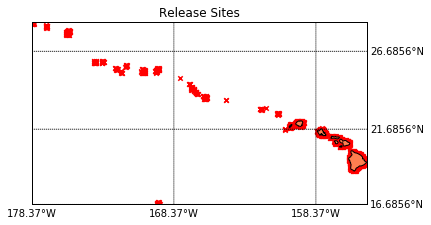

In [94]:
mapper = Basemap(projection='merc',
                 llcrnrlon=np.nanmin(lon),
                 llcrnrlat=np.nanmin(lat),
                 urcrnrlon=np.nanmax(lon),
                 urcrnrlat=np.nanmax(lat),
                 resolution='i')
mapper.drawmapboundary()
mapper.drawcoastlines()
parallels = np.arange(np.nanmin(lat),np.nanmax(lat),5.)

# labels = [left,right,top,bottom]

mapper.drawparallels(parallels,labels=[False,True,True,False])

meridians = np.arange(np.nanmin(lon),np.nanmax(lon),10)
mapper.drawmeridians(meridians,labels=[True,False,False,True])

mapper.fillcontinents(color='coral',lake_color='aqua')
mapper.scatter(list(lon), list(lat), latlon=True, c='red', marker='x', s=20)

plt.title('Release Sites')

In [95]:
# Start with one release location, the 300th one

single_release_site = release_locations.iloc[300]
single_lat = release_locations['latitude'][300]
single_lon = release_locations['longitude'][300]

In [96]:
single_release_site

value              0.04783
name                 Kauai
code         Erik Franklin
latitude           22.1045
longitude         -159.792
Name: 300, dtype: object

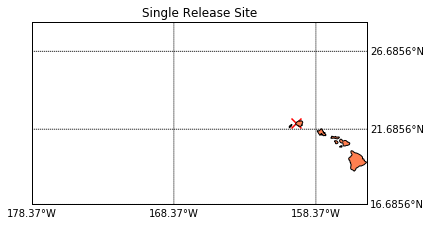

In [40]:
# Show location on map
mapper = Basemap(projection='merc',
                 llcrnrlon=np.nanmin(lon),
                 llcrnrlat=np.nanmin(lat),
                 urcrnrlon=np.nanmax(lon),
                 urcrnrlat=np.nanmax(lat),
                 resolution='i')
mapper.drawmapboundary()
mapper.drawcoastlines()
parallels = np.arange(np.nanmin(lat),np.nanmax(lat),5.)

# labels = [left,right,top,bottom]

mapper.drawparallels(parallels,labels=[False,True,True,False])

meridians = np.arange(np.nanmin(lon),np.nanmax(lon),10)
mapper.drawmeridians(meridians,labels=[True,False,False,True])

mapper.fillcontinents(color='coral',lake_color='aqua')
mapper.scatter(single_lon, single_lat, latlon=True, c='red', marker='x', s=100)

plt.title('Single Release Site')

In [98]:
# How many times to repeat
npart = 10

In [99]:
#Release from the same set of locations every day
# now = time.time()

# repeatdt = timedelta(days=1)  
# pset = ParticleSet(fieldset=fieldset,
#                    pclass=JITParticle,
#                    lon=np.tile(lon,npart),
#                    lat=np.tile(lat,npart),
#                    repeatdt=repeatdt)

In [110]:
k_turbVal = pset.Kernel(turbVal)        # casting the turbVal function to a kernel object

In [111]:
# Release on first day.
now = time.time()

pset = ParticleSet(fieldset=fieldset,
                   pclass=JITParticle,
                   lon=np.tile(single_lon,npart),
                   lat=np.tile(single_lat,npart))

time_elapsed = time.time()-now
print('time elapsed (s): ', time_elapsed)

('time elapsed (s): ', 0.8858489990234375)


In [123]:
# release from on March 1st, let drift for 50 days

now = time.time()

# Set random seed
rndm.seed(42)

days = 50
runtime = timedelta(days=days)

for i in range(0,3):
    
    
    pset = ParticleSet(fieldset=fieldset,
                       pclass=JITParticle,
                       lon=np.tile(single_lon,npart),
                       lat=np.tile(single_lat,npart))
    
    output_file = pset.ParticleFile(name="{}days_repeated_100_singlerelease_{}".format(days, i),
                                    outputdt=timedelta(days=1))

    pset.execute(AdvectionRK4 + k_turbVal,
                 runtime=runtime,
                 dt=timedelta(days=1),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
                 output_file=output_file)

time_elapsed = time.time()-now
print('time elapsed (s): ', time_elapsed)

INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/9x/568tyy852nx2b_w5rr1vwr8r0000gn/T/parcels-501/cb686eccce11294ccc876a1314521157.so
INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/9x/568tyy852nx2b_w5rr1vwr8r0000gn/T/parcels-501/689a76302739212547320397c504ccdb.so
INFO: Compiled JITParticleAdvectionRK4turbVal ==> /var/folders/9x/568tyy852nx2b_w5rr1vwr8r0000gn/T/parcels-501/51748aaf8c40da9f695bee977b441678.so


('time elapsed (s): ', 7.134132146835327)


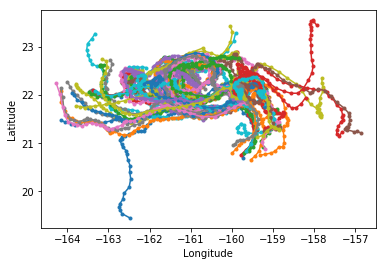

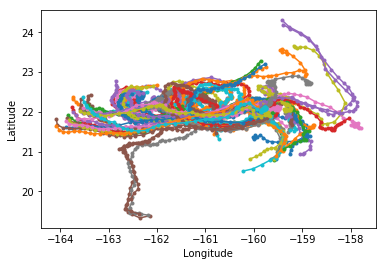

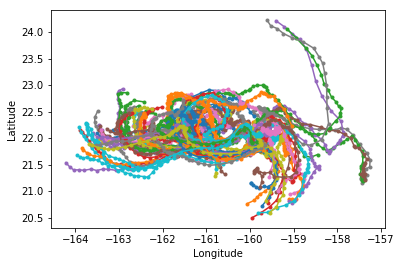

In [124]:
# PROBLEM-- Need to set a random seed somewhere! Inside the k_turbVal will just create identical traces...
for i in range(0,3):
    plotTrajectoriesFile("{}days_repeated_100_singlerelease_{}.nc".format(days,i))

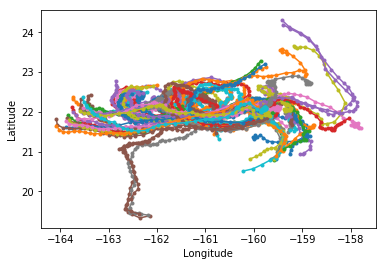

<module 'matplotlib.pyplot' from '/Users/michelleho/miniconda2/envs/py2_parcels/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [153]:
plotTrajectoriesFile("{}days_repeated_100_singlerelease_1.nc".format(days))

In [155]:
# Using just the first run, restructure the data from NC file to Dataframe
f = Dataset('{}days_repeated_100_singlerelease_0.nc'.format(days))

In [172]:
f.variables['time']

<type 'netCDF4._netCDF4.Variable'>
float64 time(trajectory, obs)
    _FillValue: nan
    long_name: 
    standard_name: time
    units: seconds since 2009-03-02 12:00:00
    calendar: julian
    axis: T
unlimited dimensions: obs
current shape = (100, 51)
filling on

In [174]:
# The particles in this simulation are released on January 1, 2010
f.variables['time'][:].min()

26352000.0

In [135]:
time = f.variables['time']
trajectory = f.variables['trajectory']
lat = f.variables['lat']
lon = f.variables['lon']

In [158]:
newdata = []
for idx in range(len(f.variables['trajectory'][:])):
    for i, t in enumerate(f.variables['time'][:][0]):
        newdata.append([idx, t, 
                        f.variables['lat'][:][idx, i], 
                        f.variables['lon'][:][idx, i]])
df = pd.DataFrame.from_records(newdata, columns=['idx', 'time', 'lat', 'lon'])

In [10]:
df.to_csv('output_50days_singlerelease.csv')

NameError: name 'df' is not defined

In [161]:
df.shape

(5100, 4)

In [13]:
day45 = 30240000.0

In [14]:
df = pd.read_csv('output_50days_singlerelease.csv')

In [15]:
# Position of 100 particles at day 45
day45_positions = df[df.time == day45]

In [16]:
day45_positions.to_csv('day45_positions.csv')

In [186]:
# Create 5km buffers around all coral sites in CARTO/postgis

In [6]:
buffered_release = pd.read_csv('Release_Sites.csv')

In [ ]:
'''
SELECT COUNT(*) FROM "michellemho-carto".day45_positions as particles, release_sites
WHERE ST_Intersects(particles.the_geom, release_sites.the_geom)
'''